In [9]:
import torch
from torch import nn
from torchmetrics import F1Score, AUROC, Precision, Recall
from torch.utils.data import DataLoader, WeightedRandomSampler

from utils.torch_classes import ECG_Dataset, EarlyStopping

from utils.rnn_models import ECG_LSTM_Classifier, ECG_GRU_Classifier

from utils.train import train_and_eval_model, val_loop, test_loop
from utils.logging import log_to_json, log_to_csv

from utils.data import calculate_class_weights, calculate_sample_weights, split_x_y

from utils.preprocessing import Preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterSampler, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, accuracy_score, classification_report

import random
import time

**TRAINING MODELS**

**Setting Seed**

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True

**Loading Preprocessed (Train+Val) Data**

In [ ]:
# load pre processed data
data_path = "data/ecg_preprocessed_train_val.npz"
data = np.load(data_path)

X = data["X"]
y = data["y"]

# # assign the weights to all of y_train
# train_sample_weights = np.array(class_weights)[y]

# train_sample_weights = torch.from_numpy(train_sample_weights).float()

# weighted_sampler = WeightedRandomSampler(
#     weights= train_sample_weights,
#     num_samples= len(train_sample_weights),
#     replacement=True,
# )

# NUM_CLASSES = len(class_weights)

**Set up KFold**

In [ ]:
K = 5
kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

**Set up Param Grid**

In [ ]:
EXPERIMENTS = 20

param_grid = {
    "model": ["LSTM", "GRU"],
    "bidirectional": [True],
    "optimizer": ["Adam", "AdamW", "SGD"],
    "momentum": np.linspace(0.9,0.999,3).tolist(),
    "batch_size": [32,64,128],
    "hidden_size": [32,64,128],
    "num_layers": [1,2],
    "dropout": [0.1,0.2,0.3,0.5],
    "weight_decay": np.logspace(-5,-2,num=5).tolist(),
    "learning_rate": np.logspace(-4,-3,num=5).tolist(),
}

configs = list(ParameterSampler(
    param_grid,
    n_iter=EXPERIMENTS,
    random_state=42))

In [ ]:
# Print 2 configs to visualise what they look like
configs[:1]

[{'weight_decay': 0.0017782794100389228,
  'optimizer': 'AdamW',
  'num_layers': 1,
  'momentum': 0.9495,
  'model': 'GRU',
  'learning_rate': 0.0001668100537200059,
  'hidden_size': 64,
  'dropout': 0.5,
  'bidirectional': True,
  'batch_size': 128}]

**Random Search + Stratified K Fold:  
To find the best model conifguration**

In [ ]:
LOG_FOLDER = "random_search"
EPOCHS = 30

PATIENCE = 6
DELTA = 0.0001

NUM_CLASSES = 5

device = "cuda" if torch.cuda.is_available() else "cpu"

results_summary_json = []
results_summary_csv = []

# Random Search Configs
for i, params in enumerate(configs):

    print(f"-------------- Experiment {i + 1}/{len(configs)} ----------------")
    try:

        BATCH_SIZE = params['batch_size']
        OPTIM = params['optimizer']

        INPUT_SIZE = 1
        HIDDEN_SIZE = params["hidden_size"]
        NUM_LAYERS = params["num_layers"]
        DROPOUT = params["dropout"]
        BIDIRECTIONAL = params["bidirectional"]

        MOMENTUM = params["momentum"]
        LEARNING_RATE = params["learning_rate"]
        WEIGHT_DECAY = params["weight_decay"]

        MODEL = params['model']

        fold_metrics = []

        print(f"Model: {'Bi' if BIDIRECTIONAL else ''}{MODEL}")

        # Loop over Each Fold
        for fold, (train_index, val_index) in enumerate(kfold.split(X,y)):

            # Instantiating Metrics

            val_precision_metric = Precision(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
            val_recall_metric = Recall(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
            val_f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
            val_auc_metric = AUROC(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)

            print(f"\n---------Fold {fold+1}/{K} ---------\n")

            # Split into train and val subsets
            X_train_fold, y_train_fold = X[train_index], y[train_index]
            X_val_fold, y_val_fold = X[val_index], y[val_index]

            train_dataset = ECG_Dataset(X_train_fold, y_train_fold)
            val_dataset = ECG_Dataset(X_val_fold,y_val_fold)

            # Calculate the class weights
            labels, class_weights = calculate_class_weights(y_train_fold)
            sample_weights = np.array(class_weights)[y_train_fold]

            # Create Weighted Random Sampler
            weighted_sampler = WeightedRandomSampler(weights=sample_weights,
                                            num_samples=len(sample_weights),
                                            replacement=True)

            # We need to recreate the data loaders
            train_dataloader = DataLoader(
                dataset=train_dataset,
                batch_size=BATCH_SIZE,
                sampler= weighted_sampler, # this is the Random Weighted Sampler we had created earlier
                shuffle= False, # we dont need to shuffle because we are using the sampler,
                num_workers=2,
                persistent_workers=True,
                pin_memory=True
            )

            val_dataloader = DataLoader(
                dataset=val_dataset,
                batch_size=BATCH_SIZE,
                shuffle=False,
                num_workers=2,
                persistent_workers=True,
                pin_memory=True
            )

            # Create the model
            if MODEL == "LSTM":
                model = ECG_LSTM_Classifier(
                    input_size=INPUT_SIZE,
                    hidden_size=HIDDEN_SIZE,
                    num_layers=NUM_LAYERS,
                    num_classes=NUM_CLASSES,
                    dropout=DROPOUT,
                    bidirectional=BIDIRECTIONAL
                )

            elif MODEL == "GRU":
                model = ECG_GRU_Classifier(
                    input_size=INPUT_SIZE,
                    hidden_size=HIDDEN_SIZE,
                    num_layers=NUM_LAYERS,
                    num_classes=NUM_CLASSES,
                    dropout=DROPOUT,
                    bidirectional=BIDIRECTIONAL
                )

            model.to(device)

            # Create the optimiers
            if OPTIM == "Adam":
                optim = torch.optim.Adam(params=model.parameters(),
                                        lr=LEARNING_RATE,
                                        weight_decay=WEIGHT_DECAY)

            elif OPTIM == "AdamW":
                optim = torch.optim.AdamW(params=model.parameters(),
                                        lr=LEARNING_RATE,
                                        weight_decay=WEIGHT_DECAY)

            elif OPTIM == "SGD":
                optim = torch.optim.SGD(params=model.parameters(),
                                        lr=LEARNING_RATE,
                                        momentum=MOMENTUM,
                                        weight_decay=WEIGHT_DECAY)

            else:
                raise ValueError(f"Unknown optimizer: {OPTIM}")

            # Create Loss function
            loss_func = nn.CrossEntropyLoss()

            # Create Early Stopper
            early_stopper = EarlyStopping(
                    patience=PATIENCE,
                    delta=DELTA,
                    checkpoint_path=f"{LOG_FOLDER}/checkpoints/experiment_{i+1}/fold_{fold+1}.pt",
                    verbose=True)

            # Train the model
            start = time.time()
            results = train_and_eval_model(
                model=model,
                loss_fn=loss_func,
                optimizer=optim,
                device=device,

                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,

                epochs=EPOCHS, # small epoch number during this phase
                early_stopper= early_stopper,

                verbose=True,
                debug=True,

                grad_clip=True,
                max_norm=1.0
            )
            end = time.time()

            epochs_run = len(results["train_loss"])

            total_time = (end-start)
            time_per_epoch = total_time/epochs_run if epochs_run > 0 else 0 # (i+1) is the current epoch

            # Evaluate the best checkpoint
            model.load_state_dict(torch.load(early_stopper.checkpoint_path, map_location=device)["model_state_dict"])
            val_data = val_loop(model=model,
                                    val_dataloader=val_dataloader,
                                    loss_fn=loss_func,
                                    device=device)

            val_pred = torch.cat(val_data["y_pred"])
            val_true = torch.cat(val_data["y_true"])

            val_pred_logits = torch.cat(val_data["y_pred_logits"])

            # Calculate Precision, Recall, F1 and AUC
            fold_precision = val_precision_metric(val_pred.to(device), val_true.to(device)).item()
            fold_recall = val_recall_metric(val_pred.to(device), val_true.to(device)).item()
            fold_f1 = val_f1_metric(val_pred.to(device), val_true.to(device)).item()
            fold_auc = val_auc_metric(val_pred_logits.to(device), val_true.to(device)).item()

            fold_metrics.append({
                "fold": fold+1,
                "precision": fold_precision,
                "recall": fold_recall,
                "f1": fold_f1,
                "auc": fold_auc,
                "time_per_epoch": time_per_epoch,
                "epochs_run": epochs_run,
                "total_epochs": EPOCHS,
            })

            print(f"Fold {fold+1}: F1={fold_f1:.3f} | AUC={fold_auc:.3f}")

        # Agreggrate metrics across folds
        avg_recall = np.mean([m["recall"] for m in fold_metrics])
        avg_precision = np.mean([m["precision"] for m in fold_metrics])
        avg_f1 = np.mean([m["f1"] for m in fold_metrics])
        avg_auc = np.mean([m["auc"] for m in fold_metrics])

        avg_time_per_epoch = np.mean([m["time_per_epoch"] for m in fold_metrics])
        avg_epochs_run = np.mean([m["epochs_run"] for m in fold_metrics])


        results_summary_csv.append({
            "experiment": i+1,
            "avg_precision": avg_precision,
            "avg_recall": avg_recall,
            "avg_f1": avg_f1,
            "avg_auc": avg_auc,
            "avg_time_per_epoch": avg_time_per_epoch,
            "avg_epochs_run": avg_epochs_run,
            "total_epochs": EPOCHS,
        })

        if OPTIM != "SGD":
            params["momentum"] = None

        results_summary_json.append({
            "experiment": i+1,
            **params,
            "fold_metrics": fold_metrics
        })

        log_to_csv(f"{LOG_FOLDER}/results.csv", results_summary_csv)
        log_to_json(f"{LOG_FOLDER}/results.json", results_summary_json)

        print(f"\n Experiment {i+1} Done: Avg F1={avg_f1:.3f}, Avg AUC={avg_auc:.3f}\n")

    except Exception as e:
        print(f"Experiment {i+1} failed: {e}")

print("\n---------------- All Experiments Completed ----------------")


**Viewing the results Random Search + KFold**

In [ ]:
results_df = pd.read_csv("random_search/results.csv")

In [ ]:
df = results_df.sort_values(ascending=False, by="avg_f1")
df

,experiment,avg_precision,avg_recall,avg_f1,avg_auc,avg_time_per_epoch,avg_epochs_run,total_epochs
3,4,0.794229,0.927682,0.847312,0.990886,11.378656,22.4,30
5,6,0.772857,0.921454,0.829510,0.990442,6.545774,26.4,30
2,3,0.715731,0.908009,0.781035,0.986743,11.333464,22.8,30
12,13,0.706242,0.917275,0.776527,0.987067,11.581934,20.2,30
1,2,0.709749,0.913180,0.776074,0.987182,8.960396,25.4,30
10,11,0.618562,0.891366,0.690582,0.978231,6.016546,30.0,30
16,17,0.594438,0.881240,0.670317,0.974421,6.647756,29.4,30
6,7,0.581871,0.867031,0.654451,0.969175,6.662057,30.0,30
14,15,0.504912,0.835654,0.578770,0.952511,6.966311,30.0,30
18,19,0.479425,0.756033,0.525841,0.914598,6.370389,21.2,30


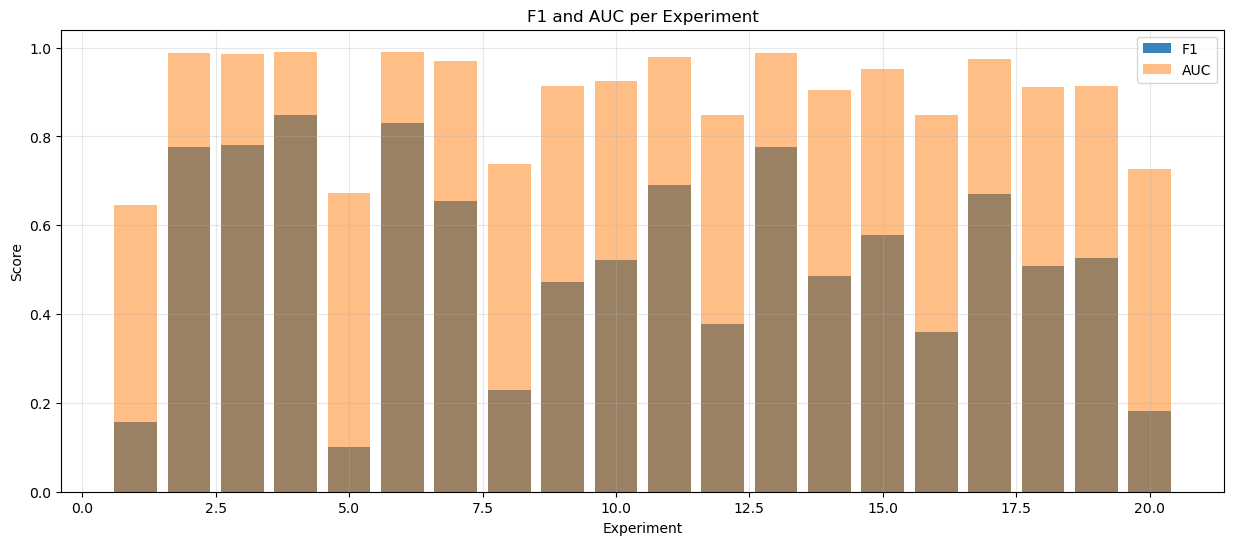

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.bar(df["experiment"], df["avg_f1"], label="F1", alpha=0.9)
plt.bar(df["experiment"], df["avg_auc"], label="AUC", alpha=0.5)
plt.xlabel("Experiment")
plt.ylabel("Score")
plt.title("F1 and AUC per Experiment")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

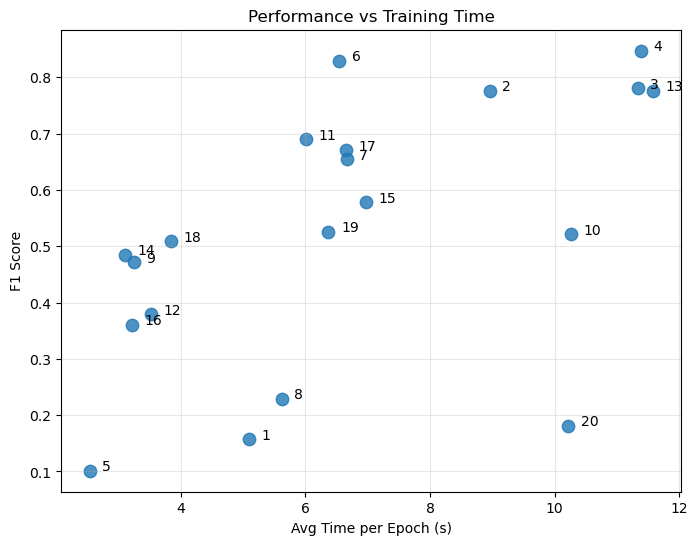

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df["avg_time_per_epoch"], df["avg_f1"], s=80, alpha=0.8)
plt.xlabel("Avg Time per Epoch (s)")
plt.ylabel("F1 Score")
plt.title("Performance vs Training Time")
plt.grid(alpha=0.3)
for i, row in df.iterrows():
    plt.text(row["avg_time_per_epoch"]+0.2, row["avg_f1"], str(int(row["experiment"])))
plt.show()

**Model Selection**  
Based on 20 random-search acorss a 5-fold Startified Cross Validation, Experiment 4 acheived the hgihest mean F1 score (0.847) with a strong AUC(0.991) and efficient convergence

This configuration provides the best balance between model accuracy and computational efficiency and was therefore selected as the final model for retraining on the combined dataset

In [3]:
# Model Hyper Params
import json

with open("random_search/results.json", "r") as f:
    results = json.load(f)

    best_exp = results[3]

    best_config = {
    "experiment": best_exp["experiment"],
    "model": best_exp["model"],
    "optimizer": best_exp["optimizer"],
    "learning_rate": best_exp["learning_rate"],
    "hidden_size": best_exp["hidden_size"],
    "num_layers": best_exp["num_layers"],
    "dropout": best_exp["dropout"],
    "weight_decay": best_exp["weight_decay"],
    "bidirectional": best_exp["bidirectional"],
    "momentum": best_exp.get("momentum", None),
    "batch_size": best_exp["batch_size"]
}

best_config

{'experiment': 4,
 'model': 'GRU',
 'optimizer': 'AdamW',
 'learning_rate': 0.001,
 'hidden_size': 128,
 'num_layers': 2,
 'dropout': 0.2,
 'weight_decay': 9.999999999999999e-06,
 'bidirectional': True,
 'momentum': None,
 'batch_size': 32}

**Setting Seed**

In [6]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True

In [7]:
# Model Hyper Params
import json

with open("random_search/results.json", "r") as f:
    results = json.load(f)

    best_exp = results[3]

    best_config = {
    "experiment": best_exp["experiment"],
    "model": best_exp["model"],
    "optimizer": best_exp["optimizer"],
    "learning_rate": best_exp["learning_rate"],
    "hidden_size": best_exp["hidden_size"],
    "num_layers": best_exp["num_layers"],
    "dropout": best_exp["dropout"],
    "weight_decay": best_exp["weight_decay"],
    "bidirectional": best_exp["bidirectional"],
    "momentum": best_exp.get("momentum", None),
    "batch_size": best_exp["batch_size"]
}

best_config

{'experiment': 4,
 'model': 'GRU',
 'optimizer': 'AdamW',
 'learning_rate': 0.001,
 'hidden_size': 128,
 'num_layers': 2,
 'dropout': 0.2,
 'weight_decay': 9.999999999999999e-06,
 'bidirectional': True,
 'momentum': None,
 'batch_size': 32}

**Training Model**

**Train Val Split (95 : 5)**

In [10]:
# load pre processed data
data_path = "data/ecg_preprocessed_train_val.npz"
data = np.load(data_path)

X = data["X"]
y = data["y"]


# Create a train val split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.05,random_state=42,stratify=y)

train_dataset = ECG_Dataset(X_train,y_train)
val_dataset = ECG_Dataset(X_val,y_val)


# Calculate weights and create our weighted sampler
labels, class_weights = calculate_class_weights(y_train)
sample_weights = np.array(class_weights)[y_train]

# Create Weighted Random Sampler
weighted_sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

**Model HyperParams**

In [14]:
# Chosen Hyper Params and Model
BATCH_SIZE = 64 # We doubled the batch size to ensure the gradients are less noisy
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT = 0.2
NUM_CLASSES = 5

# Early Stopper
PATIENCE = 12
DELTA = 0.0001
CHECKPOINT_PATH = "models/best_GRU.pt"

# Learning Rate Scheduler
LR_PATIENCE = 6
MIN_LR = 0.0001
FACTOR = 0.5

# Gradient Clipping
GRAD_CLIP = True
MAX_NORM = 1.0

EPOCHS=100

**Train Best Model**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ECG_GRU_Classifier(input_size=1,
                           hidden_size=HIDDEN_SIZE,
                           num_layers=NUM_LAYERS,
                           num_classes=NUM_CLASSES,
                           dropout=DROPOUT,
                           bidirectional=True)
model.to(device)

optimizer = torch.optim.AdamW(params=model.parameters(), weight_decay=WEIGHT_DECAY, lr=LEARNING_RATE)
loss_func = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=FACTOR,
    patience=LR_PATIENCE,
    min_lr=MIN_LR,
)

early_stopper = EarlyStopping(patience=PATIENCE, delta=DELTA,checkpoint_path=CHECKPOINT_PATH, verbose=True)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler= weighted_sampler, # this is the Random Weighted Sampler we had created earlier
    shuffle= False, # we dont need to shuffle because we are using the sampler,
    num_workers=2,
    persistent_workers=True,
    pin_memory=True
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    persistent_workers=True,
    pin_memory=True
)

train_results = train_and_eval_model(model=model, loss_fn=loss_func, optimizer=optimizer,
                     train_dataloader=train_dataloader,val_dataloader=val_dataloader,
                     epochs=EPOCHS,device=device,
                     early_stopper=early_stopper,scheduler=lr_scheduler,
                     debug=True,verbose=True,
                     grad_clip=GRAD_CLIP,max_norm=MAX_NORM)

**Plot Curves**

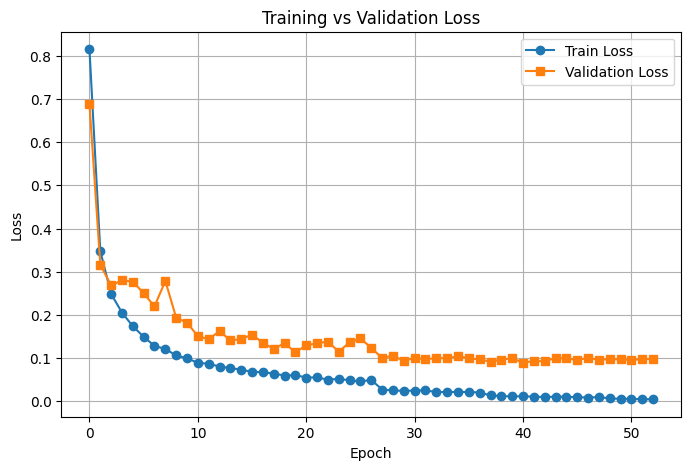

In [19]:
plt.figure(figsize=(8,5))
plt.plot(train_results["train_loss"], label="Train Loss", marker='o')
plt.plot(train_results["val_loss"], label="Validation Loss", marker='s')

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

**Prepare Test Data**

In [ ]:
# Create test data
test_df = pd.read_csv("data/mitbih_test.csv")
X_test, y_test = split_x_y(test_df)


# Preprocess test_data
preprocess = Preprocessing(
    sample_freq=125,
    cutoff_freq=25,
    order=3,
    target_r_peak_index=94,
    method="neurokit"
)

X_test_preprocessed = preprocess.transform(X_test)

test_dataset = ECG_Dataset(X_test_preprocessed, y_test)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    persistent_workers=True,
    pin_memory=True
)



**Test Model**

In [ ]:
model.load_state_dict(torch.load("models/best_GRU.pt", map_location=device)["model_state_dict"])
model.to(device)

test_results = test_loop(model,test_dataloader,device)

test_pred = test_results["y_pred"]
test_true = test_results["y_true"]
test_pred_logits = test_results["y_pred_logits"]

In [11]:
labels_list = ['N', 'S', 'V', 'F', 'Q']
print(classification_report(
    test_true,
    test_pred,
    target_names=labels_list,
    digits=4
))

              precision    recall  f1-score   support

           N     0.9915    0.9871    0.9893     18117
           S     0.7637    0.8255    0.7934       556
           V     0.9278    0.9503    0.9389      1448
           F     0.7528    0.8272    0.7882       162
           Q     0.9881    0.9776    0.9828      1608

    accuracy                         0.9787     21891
   macro avg     0.8848    0.9135    0.8985     21891
weighted avg     0.9795    0.9787    0.9790     21891

